In [1]:
pip install XlsxWriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 4.0 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


Using device: cuda
Epoch 1 | Loss: 1.0962 | Accuracy: 34.04% | Time: 25.37s
Epoch 2 | Loss: 1.0966 | Accuracy: 36.88% | Time: 9.97s
Epoch 3 | Loss: 1.1300 | Accuracy: 34.75% | Time: 9.62s
Epoch 4 | Loss: 1.0994 | Accuracy: 34.75% | Time: 9.33s
Epoch 5 | Loss: 1.0889 | Accuracy: 41.84% | Time: 9.39s
Epoch 6 | Loss: 1.0928 | Accuracy: 40.43% | Time: 8.96s
Epoch 7 | Loss: 1.1021 | Accuracy: 35.46% | Time: 9.28s
Epoch 8 | Loss: 1.0852 | Accuracy: 37.59% | Time: 8.83s
Epoch 9 | Loss: 1.0544 | Accuracy: 39.01% | Time: 9.00s
Epoch 10 | Loss: 1.0845 | Accuracy: 41.13% | Time: 9.14s
Epoch 11 | Loss: 1.0689 | Accuracy: 39.01% | Time: 9.15s
Epoch 12 | Loss: 1.0717 | Accuracy: 41.13% | Time: 9.18s
Epoch 13 | Loss: 1.0323 | Accuracy: 45.39% | Time: 9.36s
Epoch 14 | Loss: 1.0754 | Accuracy: 39.01% | Time: 9.22s
Epoch 15 | Loss: 1.0718 | Accuracy: 38.30% | Time: 9.09s
Epoch 16 | Loss: 1.0492 | Accuracy: 46.10% | Time: 8.89s
Epoch 17 | Loss: 1.0350 | Accuracy: 43.97% | Time: 9.21s
Epoch 18 | Loss: 1.0

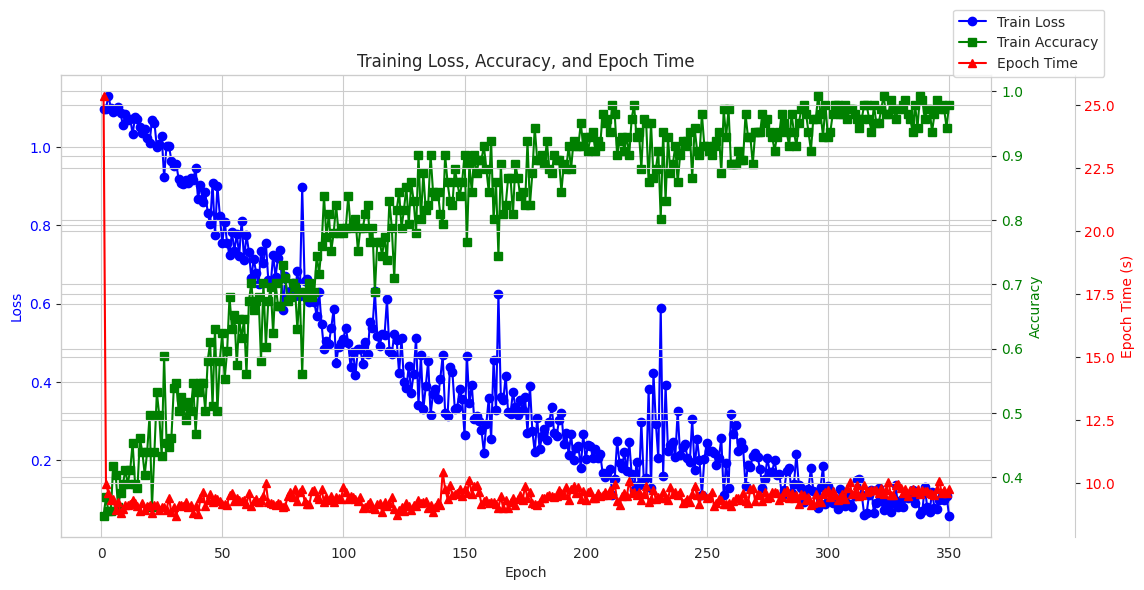

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
import os
import librosa
import numpy as np
import pywt
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report  # Added classification_report

# Ensure device compatibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====================
# 1. Dataset & Feature Extraction
# ====================

class QMSAT(Dataset):  # Renamed dataset to QMSAT
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = []
        self.labels = []
        self.class_counts = Counter()

        class_mapping = {"Music": 0, "Normal(Silence)": 1, "Tilawat-e-QuranPak": 2}

        for category in os.listdir(root_dir):
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):
                label = class_mapping.get(category, -1)
                if label == -1:
                    continue
                for file in os.listdir(category_path):
                    if file.endswith(".wav"):
                        self.file_paths.append(os.path.join(category_path, file))
                        self.labels.append(label)
                        self.class_counts[label] += 1

        # Compute class weights for balancing
        total_samples = sum(self.class_counts.values())
        self.class_weights = {k: total_samples / v for k, v in self.class_counts.items()}

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        waveform, sr = librosa.load(file_path, sr=16000)

        # Extract features
        mfcc_features = self.extract_mfcc_features(waveform)
        time_features = self.extract_time_features(waveform)
        wavelet_features = self.extract_wavelet_features(waveform)

        # Combine all features
        combined_features = np.concatenate([mfcc_features, time_features, wavelet_features])

        if combined_features.shape[0] != 25:
            raise ValueError(f"Expected 25 features, got {combined_features.shape[0]}.")
        
        return torch.tensor(combined_features, dtype=torch.float32), torch.tensor(label)

    def extract_mfcc_features(self, waveform, sr=16000, n_mfcc=13):
        mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mfcc)
        return mfccs.mean(axis=1)

    def extract_time_features(self, waveform):
        zcr = librosa.feature.zero_crossing_rate(waveform)[0].mean()
        rms = librosa.feature.rms(y=waveform)[0].mean()
        return np.array([zcr, rms])

    def extract_wavelet_features(self, waveform):
        coeffs = pywt.wavedec(waveform, 'db4', level=4)
        features = []
        for c in coeffs:
            features.append(np.mean(c) if c.size > 0 else 0)
            features.append(np.std(c) if c.size > 0 else 0)
        return np.array(features[:10])

# ====================
# 2. Initialize Dataset & DataLoader
# ====================

dataset = QMSAT(root_dir="/kaggle/input/qmsat-dataset/ATS-data")  # Using renamed dataset QMSAT
sample_weights = [dataset.class_weights[label] for label in dataset.labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
data_loader = DataLoader(dataset, batch_size=512, sampler=sampler)

# ====================
# 3. Model Definition
# ====================

class CalmnessAnalysisModel(nn.Module):
    def __init__(self, input_dim=25, hidden_dim=256, num_classes=3):
        super(CalmnessAnalysisModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, audio_features):
        # Add sequence dimension
        audio_features = audio_features.unsqueeze(1)
        lstm_out, _ = self.lstm(audio_features)
        lstm_out = lstm_out[:, -1, :]
        x = self.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ====================
# 4. Training Process
# ====================

model = CalmnessAnalysisModel(input_dim=25).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, epoch_times = [], [], []
best_loss = float('inf')
best_epoch = 0
best_model_wts = copy.deepcopy(model.state_dict())

total_start_time = time.time()

for epoch in range(350):
    model.train()
    correct, total = 0, 0
    epoch_loss = 0
    epoch_start_time = time.time()

    for audio_features, labels in data_loader:
        audio_features, labels = audio_features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(audio_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    epoch_duration = time.time() - epoch_start_time
    train_losses.append(epoch_loss)
    train_accuracies.append(correct / total)
    epoch_times.append(epoch_duration)

    print(f"Epoch {epoch + 1} | Loss: {epoch_loss:.4f} | Accuracy: {100 * (correct / total):.2f}% | Time: {epoch_duration:.2f}s")

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch + 1
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "/kaggle/working/best_calmness_analysis_model.pth")

# Save the best model
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "/kaggle/working/calmness_analysis_model.pth")

# -------------------------------
# Print Model Summary & Parameters
# -------------------------------

print("\nModel Summary:")
from torchinfo import summary
print(summary(model, input_size=(512, 25), col_names=["input_size", "output_size", "num_params", "mult_adds"], depth=2))

# -------------------------------
# Print Total GPU Training Time & Hyperparameters
# -------------------------------
total_training_time = time.time() - total_start_time
print(f"\nTotal GPU Training Time: {total_training_time:.2f} seconds")
print("Hyperparameters Used:")
print("Learning Rate: 0.005")
print("Epochs: 350")
print("Batch Size: 512")
print("Input Dimension: 25")
print("Hidden Dimension: 256")
print("Dropout: 0.3")
print("Optimizer: Adam")
print("Criterion: CrossEntropyLoss")

# ====================
# 5. Training Results & Visualization
# ====================

df = pd.DataFrame({
    "Epoch": range(1, len(train_losses) + 1),
    "Loss": train_losses,
    "Accuracy": train_accuracies,
    "Time (s)": epoch_times
})
df.to_excel("/kaggle/working/training_results.xlsx", index=False)

# Professional Plot with Multiple Subplots
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df["Epoch"], df["Loss"], marker="o", label="Train Loss", color="blue")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss", color="blue")
ax.tick_params(axis="y", labelcolor="blue")

ax2 = ax.twinx()
ax2.plot(df["Epoch"], df["Accuracy"], marker="s", label="Train Accuracy", color="green")
ax2.set_ylabel("Accuracy", color="green")
ax2.tick_params(axis="y", labelcolor="green")

ax3 = ax.twinx()
ax3.spines["right"].set_position(("outward", 60))
ax3.plot(df["Epoch"], df["Time (s)"], marker="^", label="Epoch Time", color="red")
ax3.set_ylabel("Epoch Time (s)", color="red")
ax3.tick_params(axis="y", labelcolor="red")

plt.title("Training Loss, Accuracy, and Epoch Time")
fig.legend(loc="upper right", bbox_to_anchor=(1,1))
plt.savefig("/kaggle/working/training_performance.jpeg", dpi=300)
plt.show()

# ------------------------------- 
# Save All Results to Excel
# -------------------------------

# Save all results to a single Excel file with multiple sheets
hyperparameters = {
    "Learning Rate": 0.005,
    "Epochs": 350,
    "Batch Size": 512,
    "Input Dimension": 25,
    "Hidden Dimension": 256,
    "Dropout": 0.3,
    "Optimizer": "Adam",
    "Criterion": "CrossEntropyLoss",
    "Total GPU Training Time (s)": total_training_time
}

hyper_df = pd.DataFrame(list(hyperparameters.items()), columns=["Parameter", "Value"])

with pd.ExcelWriter("/kaggle/working/all_results.xlsx") as writer:
    df.to_excel(writer, sheet_name="Training Results", index=False)
    hyper_df.to_excel(writer, sheet_name="Hyperparameters", index=False)

Using device: cuda
Processing Music: /kaggle/input/qmsat-dataset/ATS-data/Music/13_music_f_3.wav
Processing Normal(Silence): /kaggle/input/qmsat-dataset/ATS-data/Normal(Silence)/10_normal_m_8.wav
Processing Tilawat-e-QuranPak: /kaggle/input/qmsat-dataset/ATS-data/Tilawat-e-QuranPak/1_quran_f_23.wav


<ipython-input-3-3846a3853707>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/calmness_analysis_model.pth", map_location

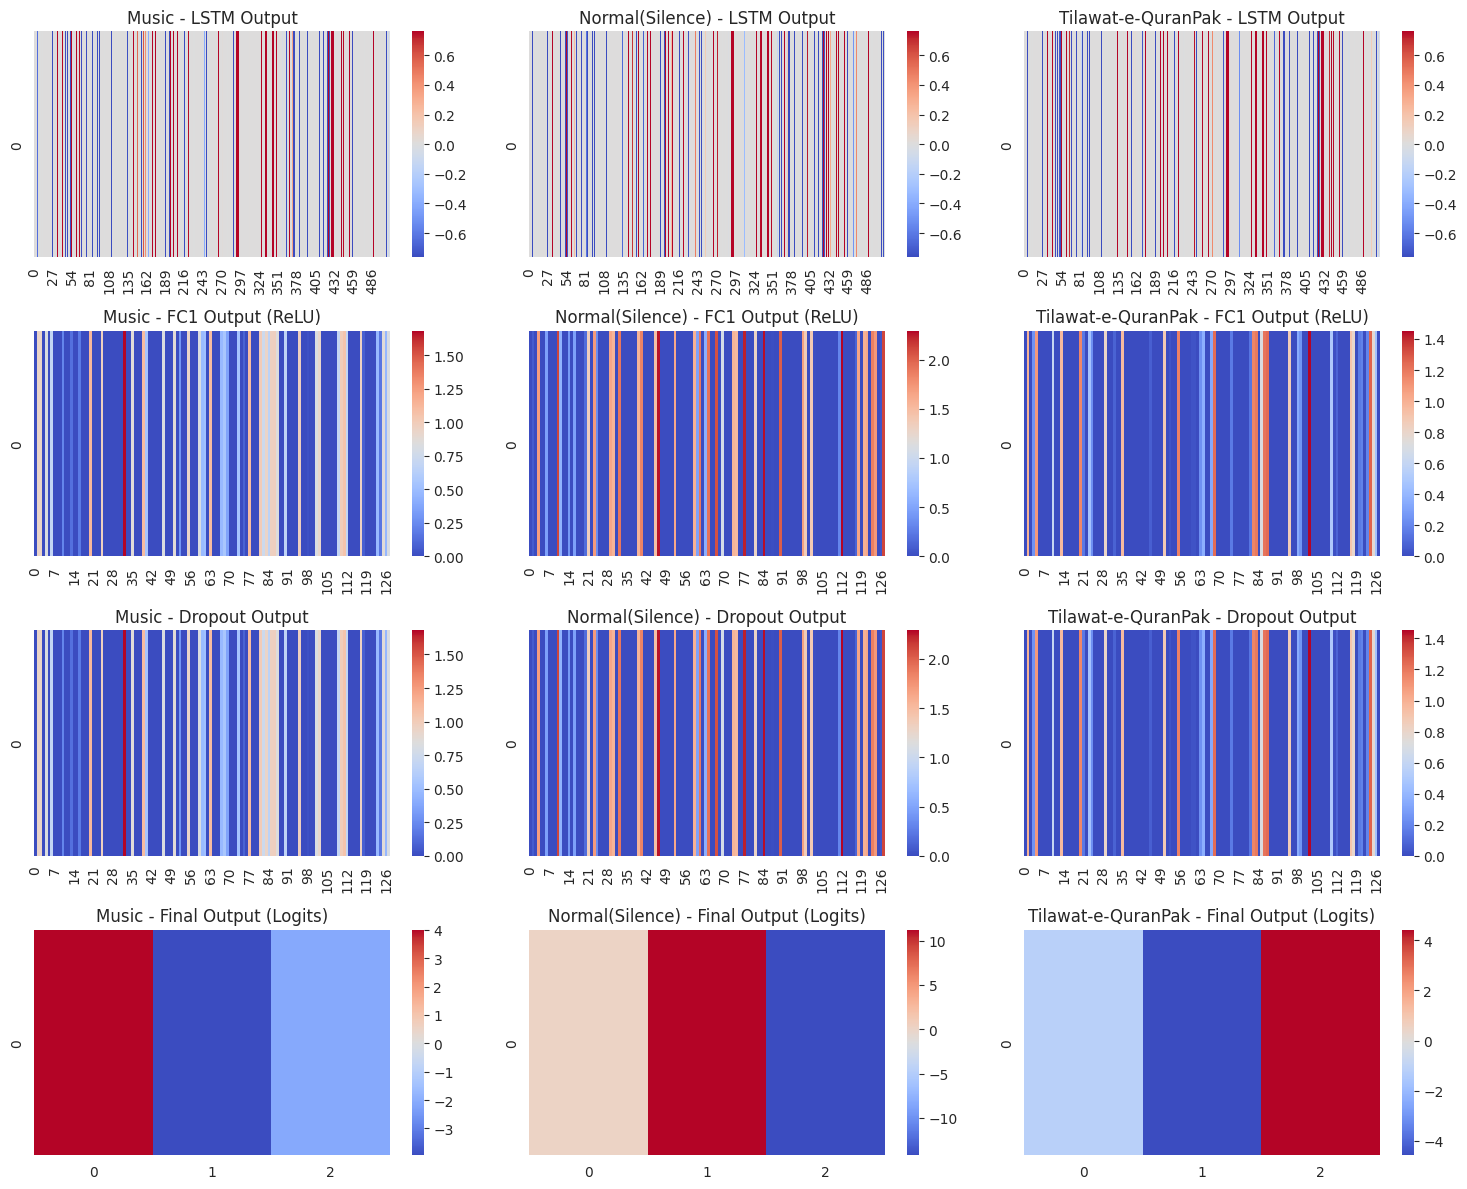

Layer-wise visualization saved as 'layer_visualization.jpeg'.


In [3]:
import torch
import torch.nn as nn
import librosa
import numpy as np
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure device compatibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===========================
# 1. Load Trained Model
# ===========================
class CalmnessAnalysisModel(nn.Module):
    def __init__(self, input_dim=25, hidden_dim=256, num_classes=3):
        super(CalmnessAnalysisModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, audio_features):
        layer_outputs = {}

        # Input to LSTM
        audio_features = audio_features.unsqueeze(1)  # Reshape for LSTM
        lstm_out, _ = self.lstm(audio_features)
        lstm_out = lstm_out[:, -1, :]  # Take last time-step output
        layer_outputs["LSTM Output"] = lstm_out.detach().cpu().numpy()

        # Fully Connected Layer 1
        x = self.relu(self.fc1(lstm_out))
        layer_outputs["FC1 Output (ReLU)"] = x.detach().cpu().numpy()

        # Dropout Layer
        x = self.dropout(x)
        layer_outputs["Dropout Output"] = x.detach().cpu().numpy()

        # Fully Connected Layer 2 (Final Output)
        x = self.fc2(x)
        layer_outputs["Final Output (Logits)"] = x.detach().cpu().numpy()

        return x, layer_outputs

# Load the trained model
model = CalmnessAnalysisModel(input_dim=25).to(device)
model.load_state_dict(torch.load("/kaggle/working/calmness_analysis_model.pth", map_location=device))
model.eval()

# ===========================
# 2. Load Sample Audio from Each Class
# ===========================
dataset_path = "/kaggle/input/qmsat-dataset/ATS-data"
categories = ["Music", "Normal(Silence)", "Tilawat-e-QuranPak"]

sample_files = {}
for category in categories:
    category_path = os.path.join(dataset_path, category)
    for file in os.listdir(category_path):
        if file.endswith(".wav"):
            sample_files[category] = os.path.join(category_path, file)
            break  # Pick only one sample per category

# ===========================
# 3. Feature Extraction Function
# ===========================
def extract_features(file_path):
    waveform, sr = librosa.load(file_path, sr=16000)

    # MFCC Features
    mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=13).mean(axis=1)

    # Time Features (Zero-Crossing Rate & RMS)
    zcr = librosa.feature.zero_crossing_rate(waveform)[0].mean()
    rms = librosa.feature.rms(y=waveform)[0].mean()

    # Wavelet Transform Features
    coeffs = pywt.wavedec(waveform, 'db4', level=4)
    wavelet_features = []
    for c in coeffs:
        wavelet_features.append(np.mean(c) if c.size > 0 else 0)
        wavelet_features.append(np.std(c) if c.size > 0 else 0)
    wavelet_features = wavelet_features[:10]  # Keep first 10 features

    return np.concatenate([mfccs, [zcr, rms], wavelet_features])

# ===========================
# 4. Process Audio Through Model
# ===========================
layer_outputs_per_class = {}

for category, file_path in sample_files.items():
    print(f"Processing {category}: {file_path}")

    # Extract features
    features = extract_features(file_path)
    features_tensor = torch.tensor(features, dtype=torch.float32).to(device).unsqueeze(0)

    # Pass through the model and get layer outputs
    _, layer_outputs = model(features_tensor)
    layer_outputs_per_class[category] = layer_outputs

# ===========================
# 5. Visualization of Layer Outputs
# ===========================
sns.set_style("whitegrid")
fig, axes = plt.subplots(len(layer_outputs), len(categories), figsize=(15, 12))

# Iterate over layers
for layer_idx, (layer_name, _) in enumerate(layer_outputs_per_class["Music"].items()):
    for category_idx, category in enumerate(categories):
        output_data = layer_outputs_per_class[category][layer_name]

        # Plot as a heatmap for better visualization
        sns.heatmap(output_data, ax=axes[layer_idx, category_idx], cmap="coolwarm", cbar=True)
        axes[layer_idx, category_idx].set_title(f"{category} - {layer_name}")

plt.tight_layout()
plt.savefig("/kaggle/working/layer_visualization.jpeg", dpi=300)
plt.show()

print("Layer-wise visualization saved as 'layer_visualization.jpeg'.")


<ipython-input-4-6bc99b08a138>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


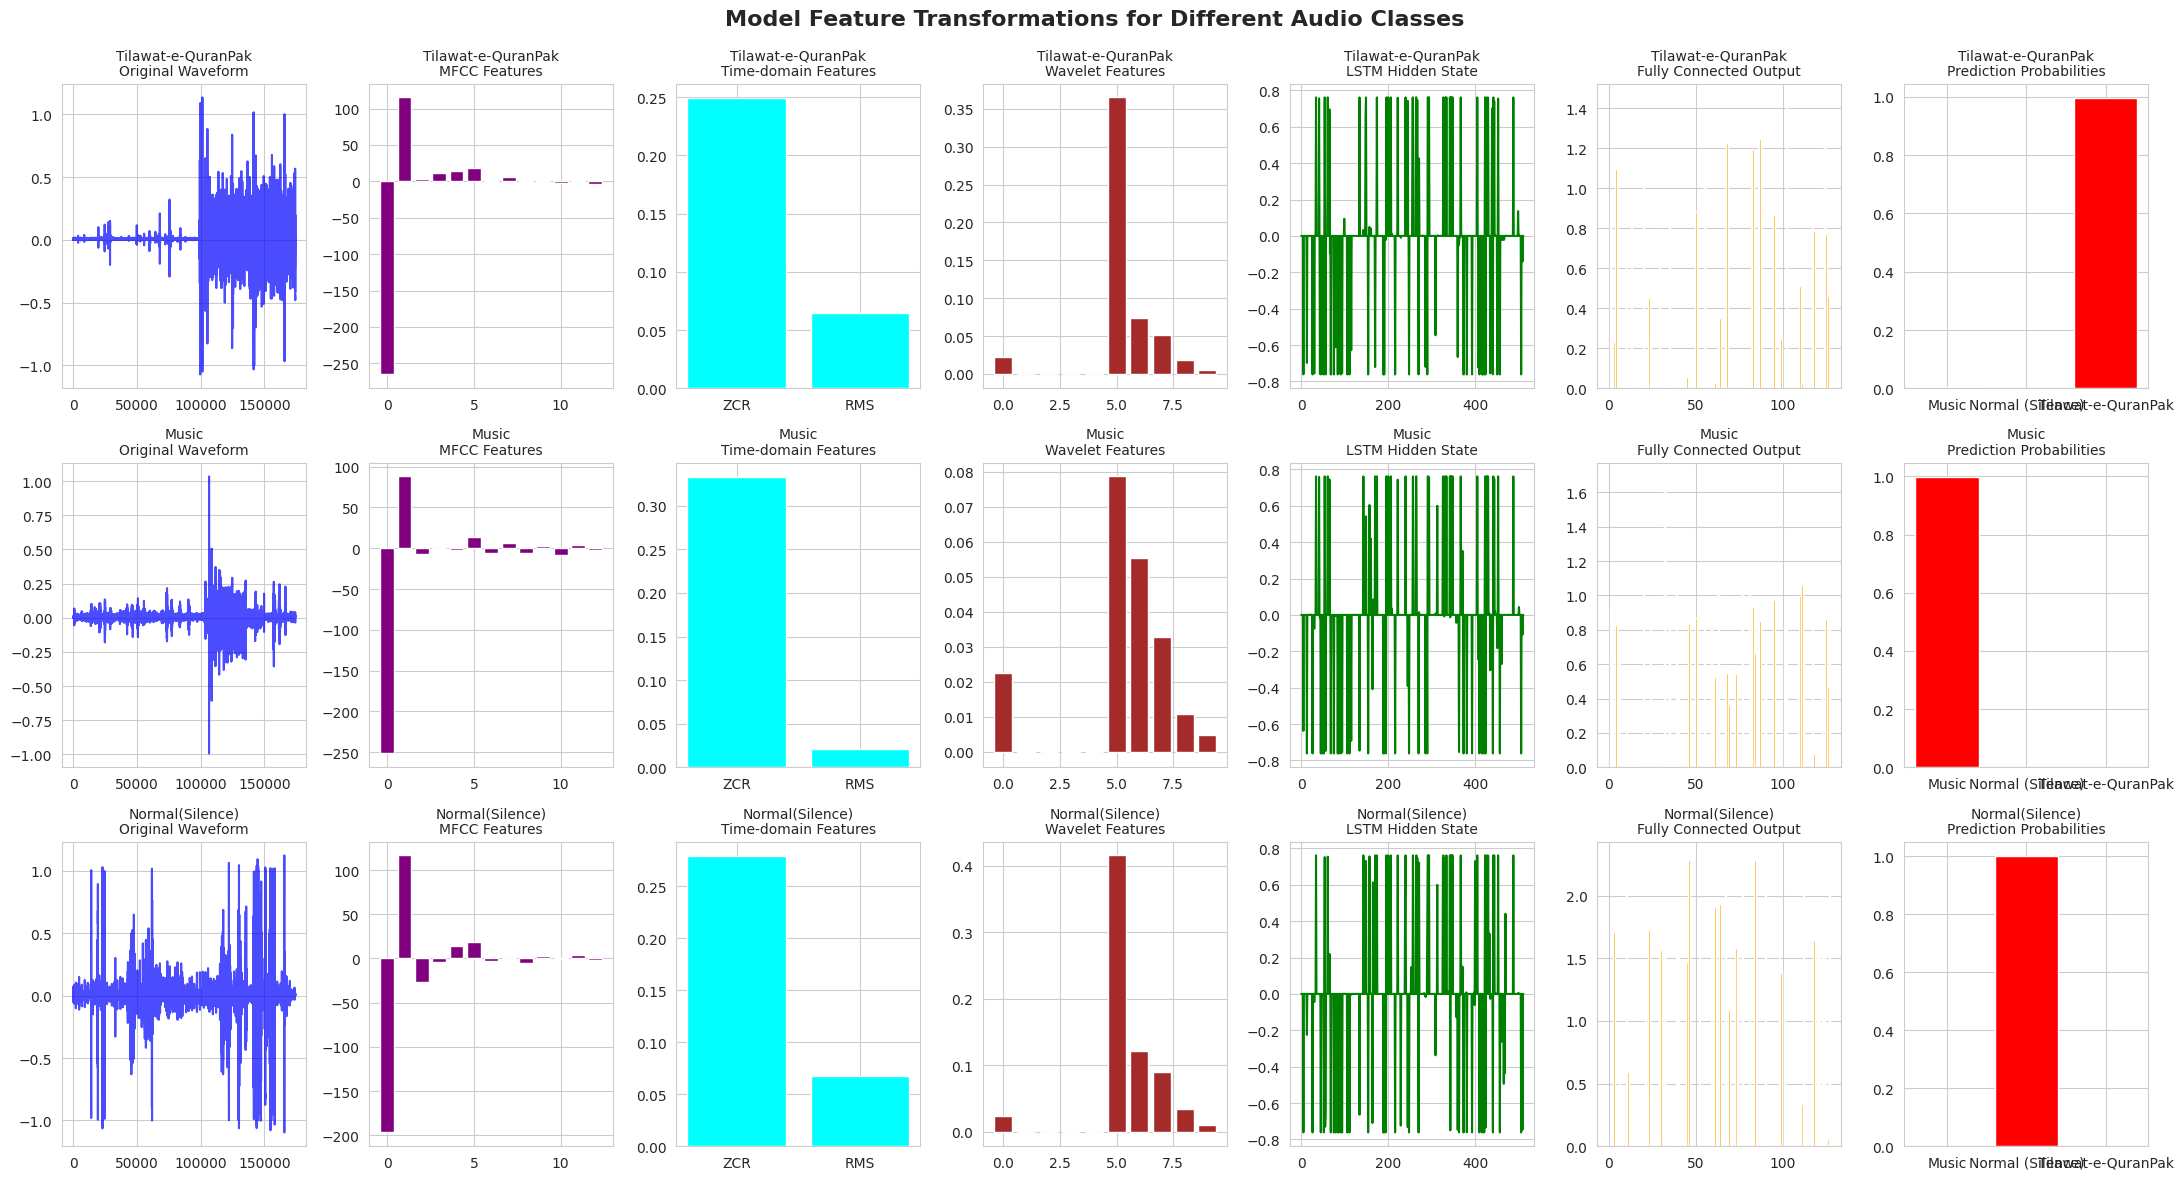

In [4]:
import torch
import torch.nn as nn
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pywt

# Set visualization style
sns.set_style("whitegrid")

# Load trained model
model_path = "/kaggle/working/calmness_analysis_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class names
class_labels = {0: "Music", 1: "Normal (Silence)", 2: "Tilawat-e-QuranPak"}

# Load model
class CalmnessAnalysisModel(nn.Module):
    def __init__(self, input_dim=25, hidden_dim=256, num_classes=3):
        super(CalmnessAnalysisModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, audio_features):
        audio_features = audio_features.unsqueeze(1)
        lstm_out, _ = self.lstm(audio_features)
        lstm_out = lstm_out[:, -1, :]
        fc1_out = self.relu(self.fc1(lstm_out))  # Extract FC1 activations
        x = self.dropout(fc1_out)
        x = self.fc2(x)
        return lstm_out, fc1_out, x  # Return FC1 activations

# Load the trained model
model = CalmnessAnalysisModel(input_dim=25).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# =====================
# 1. Load & Preprocess an Example Audio from Each Class
# =====================

def extract_features(waveform, sr=16000):
    """Extracts MFCC, time-domain, and wavelet features."""
    # MFCC Features
    mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=13).mean(axis=1)

    # Time-domain Features
    zcr = librosa.feature.zero_crossing_rate(waveform)[0].mean()
    rms = librosa.feature.rms(y=waveform)[0].mean()
    time_features = np.array([zcr, rms])

    # Wavelet Features
    coeffs = pywt.wavedec(waveform, 'db4', level=4)
    wavelet_features = [np.mean(c) if c.size > 0 else 0 for c in coeffs[:5]] + \
                       [np.std(c) if c.size > 0 else 0 for c in coeffs[:5]]

    # Combine all features
    return np.concatenate([mfccs, time_features, wavelet_features]), time_features, wavelet_features

# Load sample audio files from each class
root_dir = "/kaggle/input/qmsat-dataset/ATS-data"
sample_files = {}

for category in os.listdir(root_dir):
    category_path = os.path.join(root_dir, category)
    if os.path.isdir(category_path):
        for file in os.listdir(category_path):
            if file.endswith(".wav"):
                sample_files[category] = os.path.join(category_path, file)
                break  # Only take one sample per category

# Prepare storage for visualization
waveforms = {}
mfcc_transforms = {}
time_features_store = {}
wavelet_features_store = {}
lstm_outputs = {}
fc1_outputs = {}
final_outputs = {}

fig, axes = plt.subplots(len(sample_files), 7, figsize=(22, 12))

# =====================
# 2. Pass Through Model and Visualize Transformations
# =====================

for idx, (category, file_path) in enumerate(sample_files.items()):
    # Load audio
    waveform, sr = librosa.load(file_path, sr=16000)
    waveforms[category] = waveform

    # Extract features
    features, time_features, wavelet_features = extract_features(waveform)
    features_tensor = torch.tensor(features, dtype=torch.float32).to(device).unsqueeze(0)

    # Pass through model
    with torch.no_grad():
        lstm_out, fc1_out, final_out = model(features_tensor)

    # Store transformations
    mfcc_transforms[category] = features[:13]  # MFCC components
    time_features_store[category] = time_features  # ZCR & RMS
    wavelet_features_store[category] = wavelet_features  # Wavelet Features
    lstm_outputs[category] = lstm_out.cpu().numpy().squeeze()  # LSTM Hidden state
    fc1_outputs[category] = fc1_out.cpu().numpy().squeeze()  # Corrected FC1 output
    final_outputs[category] = final_out.cpu().numpy().squeeze()  # Final output (logits)

    # =====================
    # 3. Plot Layer-by-Layer Transformations
    # =====================

    # 1. Original Waveform
    axes[idx, 0].plot(waveform, color="blue", alpha=0.7)
    axes[idx, 0].set_title(f"{category}\nOriginal Waveform", fontsize=10)

    # 2. MFCC Features
    axes[idx, 1].bar(range(13), mfcc_transforms[category], color="purple")
    axes[idx, 1].set_title(f"{category}\nMFCC Features", fontsize=10)

    # 3. Time-domain Features (ZCR & RMS)
    axes[idx, 2].bar(["ZCR", "RMS"], time_features_store[category], color="cyan")
    axes[idx, 2].set_title(f"{category}\nTime-domain Features", fontsize=10)

    # 4. Wavelet Features
    axes[idx, 3].bar(range(len(wavelet_features_store[category])), wavelet_features_store[category], color="brown")
    axes[idx, 3].set_title(f"{category}\nWavelet Features", fontsize=10)

    # 5. LSTM Hidden State
    axes[idx, 4].plot(lstm_outputs[category], color="green")
    axes[idx, 4].set_title(f"{category}\nLSTM Hidden State", fontsize=10)

    # 6. Fully Connected Layer Output
    if len(fc1_outputs[category]) == 128:
        axes[idx, 5].bar(range(128), fc1_outputs[category], color="orange")
        axes[idx, 5].set_title(f"{category}\nFully Connected Output", fontsize=10)
    else:
        print(f"Warning: Unexpected shape {fc1_outputs[category].shape} in FC1 output.")

    # 7. Softmax Prediction (Final Probabilities)
    softmax_probs = torch.softmax(torch.tensor(final_outputs[category]), dim=0).numpy()
    axes[idx, 6].bar(list(class_labels.values()), softmax_probs, color="red")
    axes[idx, 6].set_title(f"{category}\nPrediction Probabilities", fontsize=10)

# Adjust layout and fix title overlaps
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("Model Feature Transformations for Different Audio Classes", fontsize=16, fontweight='bold')
plt.savefig("/kaggle/working/model_visualization.jpeg", dpi=300)
plt.show()
